In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch

sys.path.append(os.path.abspath(".."))

from models.lstm import create_model, evaluate_model, train_model
from utils.plotting import plot_train_val, plot_train_val_losses, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              add_weather_forecast, create_sequences,
                              encode_categoricals, interpolate_missing_hours,
                              split_train_val)

True


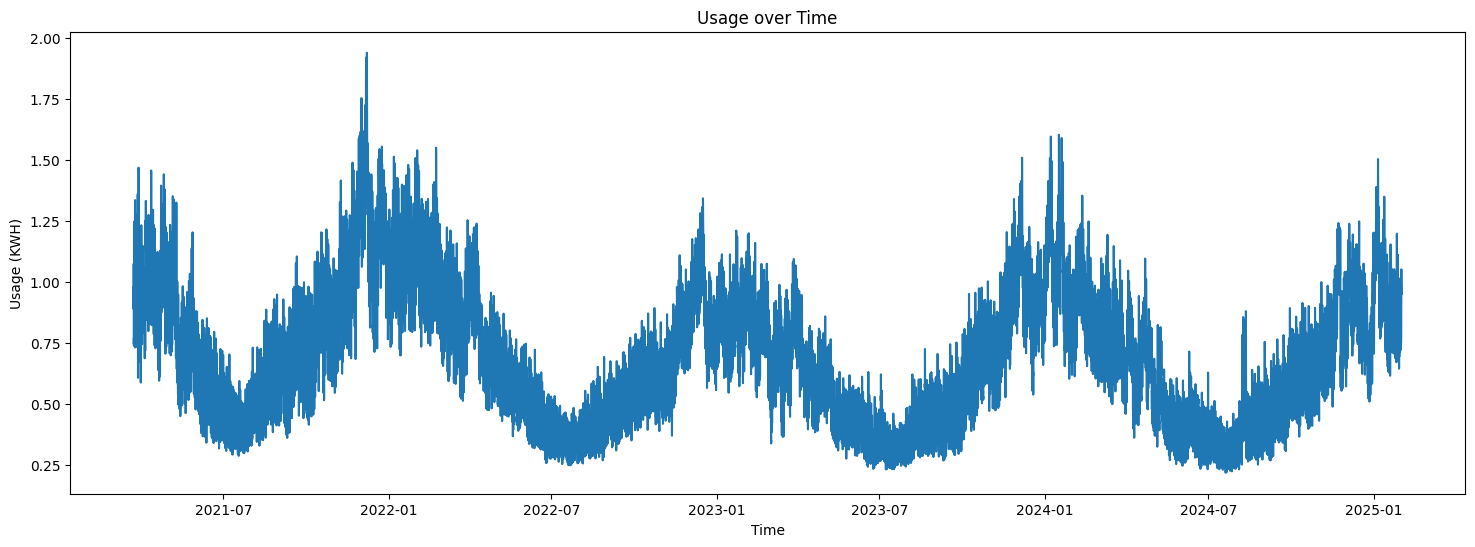

In [2]:
df = pd.read_csv('../data/consumption/dataset.csv')

df['USAGE_AT'] = pd.to_datetime(df['USAGE_AT'])
df['diff'] = df['USAGE_AT'].diff()

# Exclude the first row (where .diff() is NaT)
df_valid = df[df['diff'].notna()]

# Now check if all differences are exactly 1 hour
all_hourly = (df_valid['diff'] == pd.Timedelta(hours=1)).all()
df = df.drop(columns='diff')
print(all_hourly)

plot_usage(df)

In [3]:
preprocessed_df = encode_categoricals(df)

preprocessed_df

,USAGE_AT,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,USAGE_KWH
0,2021-03-23 00:00:00+00:00,2.6,0.0,0.0,0.0,7.1,0.000000,1.000000,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.976258
1,2021-03-23 01:00:00+00:00,2.6,0.0,0.0,0.0,7.1,0.258819,0.965926,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.964150
2,2021-03-23 02:00:00+00:00,2.5,0.0,0.0,0.0,7.2,0.500000,0.866025,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.953400
3,2021-03-23 03:00:00+00:00,2.4,0.0,0.0,0.0,7.2,0.707107,0.707107,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.889413
4,2021-03-23 04:00:00+00:00,2.3,0.0,0.0,0.0,7.6,0.866025,0.500000,0.000000,1.000000,0.866025,0.500000,-0.968077,-0.250653,0.908430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33860,2025-01-31 20:00:00+00:00,0.7,0.0,0.0,0.0,13.3,-0.866025,0.500000,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.985828
33861,2025-01-31 21:00:00+00:00,0.3,0.0,0.0,0.0,14.4,-0.707107,0.707107,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.993425
33862,2025-01-31 22:00:00+00:00,-0.0,0.0,0.0,0.0,14.4,-0.500000,0.866025,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.987878
33863,2025-01-31 23:00:00+00:00,-0.2,0.0,0.0,0.0,14.8,-0.258819,0.965926,0.433884,-0.900969,0.000000,1.000000,-0.201299,0.979530,0.969646


In [4]:
columns = df.columns.tolist()

columns

['USAGE_AT',
 'MONTH',
 'DAY_OF_MONTH',
 'WEEKDAY',
 'HOUR',
 'temperature_2m',
 'precipitation',
 'direct_radiation',
 'uv_index',
 'wind_speed_10m',
 'USAGE_KWH',
 'hour_sin',
 'hour_cos',
 'weekday_sin',
 'weekday_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos']

In [5]:
# NOTE: Variables for Sequence generation, splitting, and scaling
sequence_length = 24
window = 24

train_split = 0.9
scaler_type = 'minmax'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X, y, feature_names = create_sequences(df, columns, sequence_length, window, return_feature_names=True)

assert len(feature_names) == X.shape[2]

(X.shape, y.shape, feature_names)

Using device: cpu


((33817, 24, 18),
 (33817,),
 ['MONTH',
  'DAY_OF_MONTH',
  'WEEKDAY',
  'HOUR',
  'temperature_2m',
  'precipitation',
  'direct_radiation',
  'uv_index',
  'wind_speed_10m',
  'hour_sin',
  'hour_cos',
  'weekday_sin',
  'weekday_cos',
  'month_sin',
  'month_cos',
  'day_sin',
  'day_cos',
  'USAGE_KWH'])

In [6]:
scale_columns = [
  'temperature_2m',
  'precipitation',
  'direct_radiation',
  'uv_index',
  'wind_speed_10m',
  'USAGE_KWH'
]

In [7]:
X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, feature_names, train_split, scaler_type, scale_columns, device)

Applying minmax scaling.
X_train shape: torch.Size([30435, 24, 18])
y_train shape: torch.Size([30435, 1])
X_val shape: torch.Size([3382, 24, 18])
y_val shape: torch.Size([3382, 1])


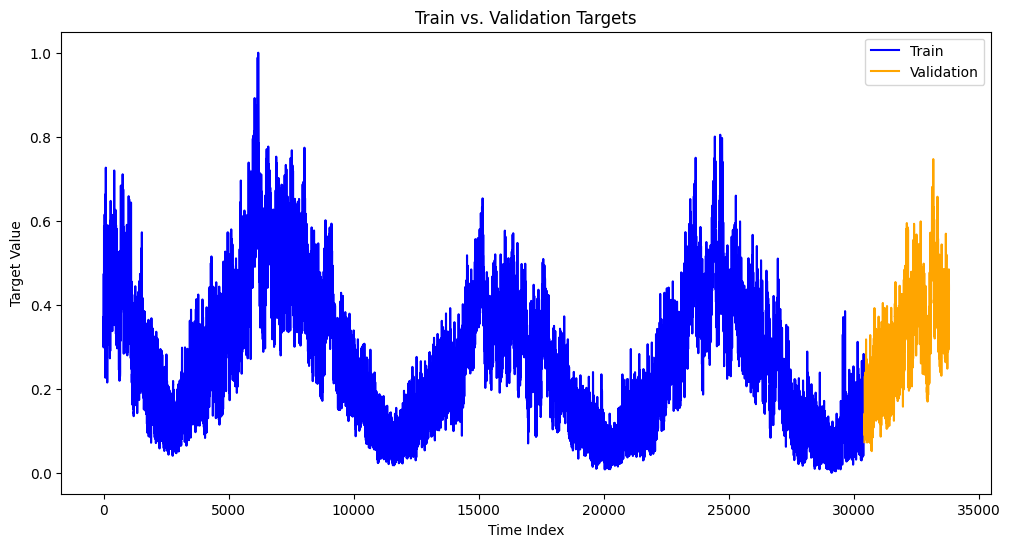

In [8]:
plot_train_val(y_train, y_val)

In [9]:
# NOTE: Model variables
input_dim = X_train.shape[2]
hidden_dim = 50
num_layers = 2
output_dim = 1

model = create_model(input_dim, hidden_dim, num_layers, output_dim, device)

model

LSTMModel(
  (lstm): LSTM(18, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [10]:
lr=0.01
gamma=0.9
noise_std=0.01
num_epochs=300

train_losses, val_losses, model = train_model(
        model, X_train, y_train, X_val, y_val,
        num_epochs, lr, gamma, noise_std
)

Applying Adaptive LR Scheduler: Step Size = 60 epochs, Decay Factor = 0.9
Applying gaussian noise: std = 0.01
Epoch 1/300, Train Loss: 0.1135, Val Loss: 0.0647
Epoch 2/300, Train Loss: 0.0961, Val Loss: 0.0250
Epoch 3/300, Train Loss: 0.0260, Val Loss: 0.0518
Epoch 4/300, Train Loss: 0.0457, Val Loss: 0.0497
Epoch 5/300, Train Loss: 0.0438, Val Loss: 0.0363
Epoch 6/300, Train Loss: 0.0336, Val Loss: 0.0236
Epoch 7/300, Train Loss: 0.0253, Val Loss: 0.0161
Epoch 8/300, Train Loss: 0.0224, Val Loss: 0.0140
Epoch 9/300, Train Loss: 0.0242, Val Loss: 0.0146
Epoch 10/300, Train Loss: 0.0270, Val Loss: 0.0145
Epoch 11/300, Train Loss: 0.0272, Val Loss: 0.0136
Epoch 12/300, Train Loss: 0.0251, Val Loss: 0.0132
Epoch 13/300, Train Loss: 0.0226, Val Loss: 0.0141
Epoch 14/300, Train Loss: 0.0213, Val Loss: 0.0160
Epoch 15/300, Train Loss: 0.0211, Val Loss: 0.0181
Epoch 16/300, Train Loss: 0.0217, Val Loss: 0.0197
Epoch 17/300, Train Loss: 0.0223, Val Loss: 0.0203
Epoch 18/300, Train Loss: 0.0224

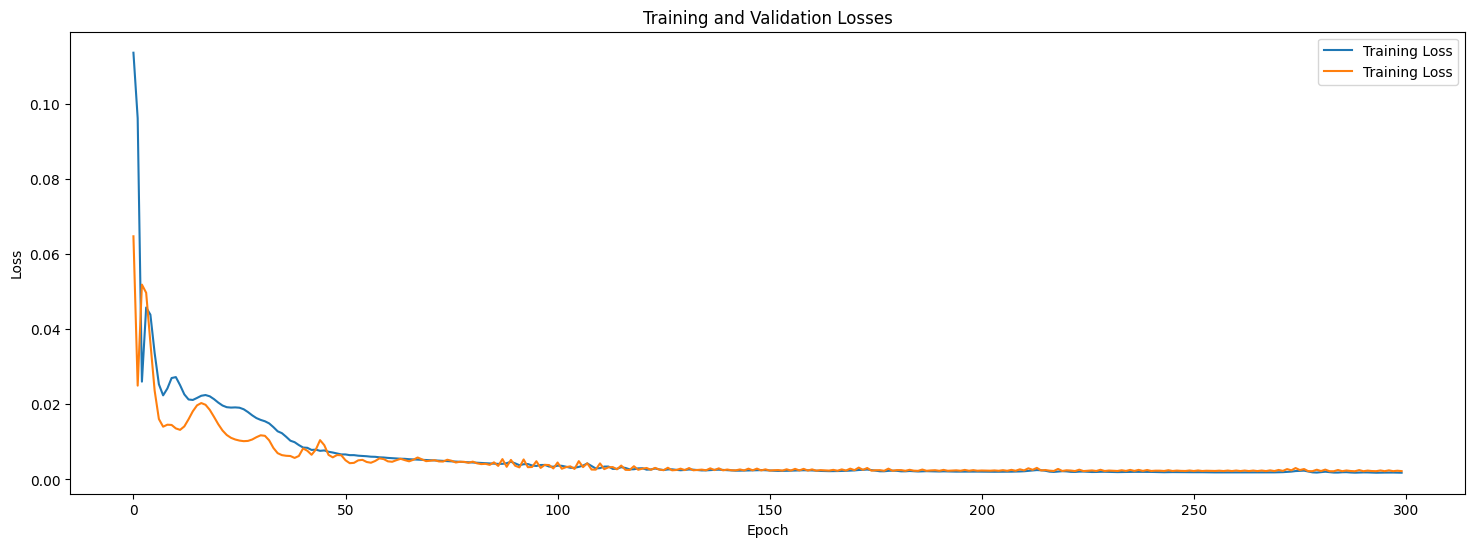

In [11]:
plot_train_val_losses(train_losses, val_losses)

MAE: 0.0613
MAPE: 8.42%
RMSE: 0.0811
kWh actual: 2545.349853515625, kWh pred: 2566.200439453125, diff (%): 0.8191638588905334


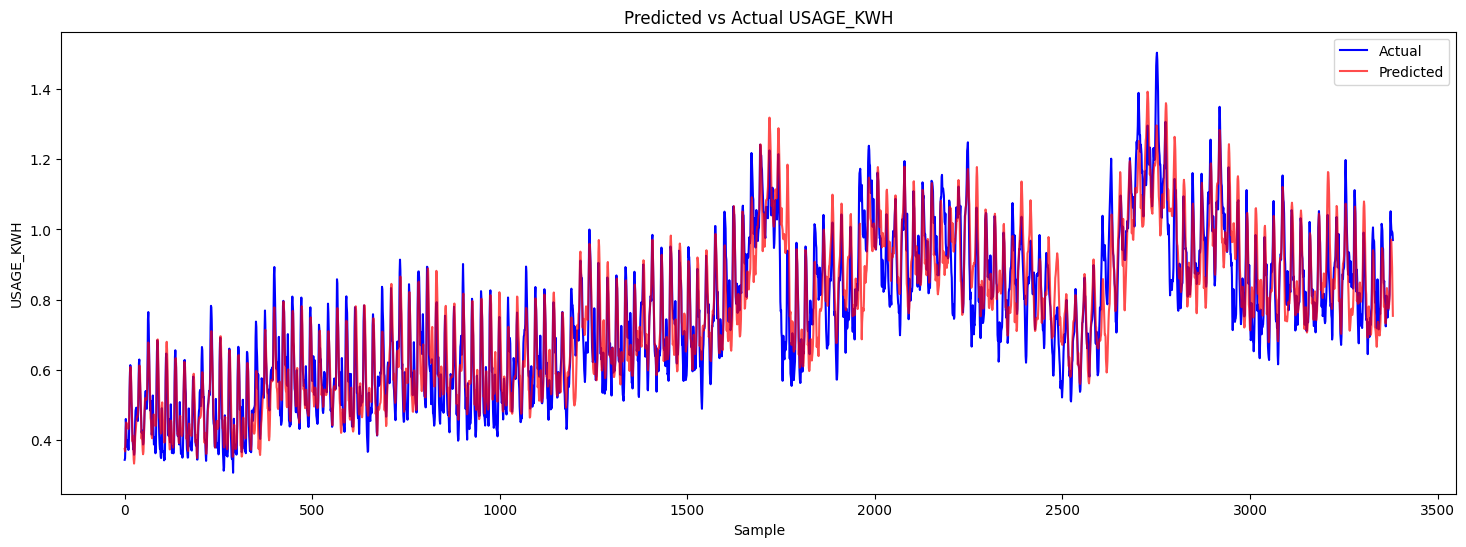

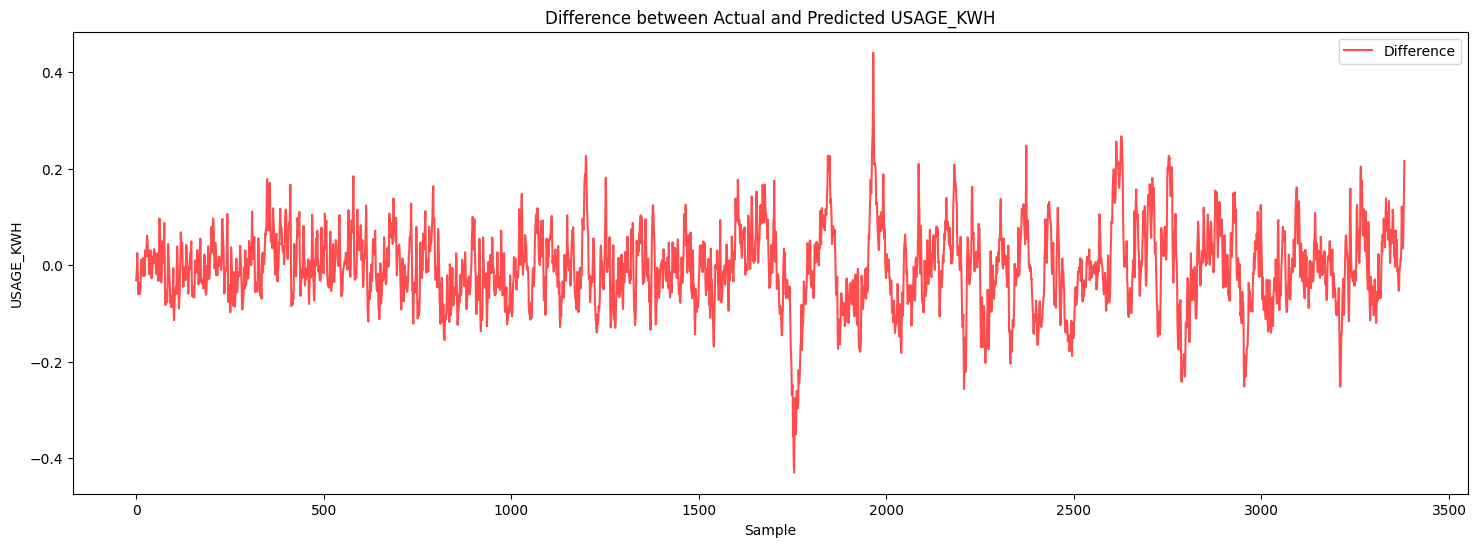

In [12]:
_ = evaluate_model(model, X_val, y_val, scaler_y)